## Graph Theory Homework 2

In [42]:
## COMMON LIBRARIES WHICH CAN BE USED FOR THREE SECTIONS ##
import numpy as np
import scipy.io as sp
import matplotlib.pyplot as plt
import pandas as pd
from sys import maxsize

from PIL import Image
from pylab import *
from scipy.cluster.vq import *
from skimage import data, segmentation, color
from skimage.transform import rescale, resize

### 1 Bellman-Ford shortest path algorithm
**(1.1) Explain the key steps of Bellman-Ford algorithm (one-by-one).** <br> <br>
The key steps of the Bellman-Ford Algorithm:
1. **INPUT** &nbsp; &nbsp; : Let _A = 2D_ weighted and directed adjacency matrix with _n\*n_, where _n_ is the number of vertices <br />
   **OUTPUT** : Distances from source to all other reachable nodes from the source node; and previous nodes for the shortest path
2. Set distance 0 (zero) to the source node and infinity for others
3. Loop over _(n-1)_ step to calculate and update the distance
4. Save the distances and previous nodes for that path 
5. Check the negative cycles
6. If no negative cycles then show the result, otherwise give an error message 
<hr>

**(1.2) Write a function called BellmanFordAlgo that takes (i) A and (2) a starting node ID as inputs, and outputs an array as in Graph Theory Blink 5.4, where each row represents a node in the graph G and comprising three columns (nodes, shortest distance from source input node, previous node).**

In [10]:
def GetEdgeList(A , v):
    E = []
    for i in range(0, v):
        for j in range(0, v):
            if(A[i,j] != 0):
                E.append((i,j,A[i,j]))
    return E

def BellmanFordAlgo(A, source):
    V = np.matrix(A).shape[0]    # number of vertices
    d = np.array([maxsize] * V, dtype=np.float64)  # distance vector
    v = np.array([-1] * V, dtype=np.float64)       # vertices vector to trace previous vertices
    d[source] = 0                # initialize the start node
    E = GetEdgeList(A,V)         # get the edge list with format (u, v, w) -> (source_node, end_node, weight)

    
    # The result is the return value of the function, where each row represents a node in the graph G 
    #and comprising three columns (nodes, shortest distance from source input node, previous node). 
    result =  np.array([[j if i == 0 else maxsize for i in range(3)] for j in range(V)], dtype=np.float64)
    #print(result)
    # At-most, the algorithm can find the shortest path from the source to all other nodes at (V-1) steps
    # where V is the number of vertices. Therefore iterate over (V-1) times
    # Then for each edge, check for shortest path
    for i in range(V):
        for j in E:
            if((d[j[0]] != maxsize) and (d[j[1]] > d[j[0]] + j[2])):
                d[j[1]] = d[j[0]] + j[2]
                v[j[1]] = j[0]

    # After max itereation count (V-1), we know that we must have the shortest path to all other nodes
    # But if we have negative cycles in the graph, then the below iteration will find more shorter path
    # Check for negative weighted cycles, if exists then return an error message
    for i in E: 
        if((d[j[0]] != maxsize) and (d[j[1]] > d[j[0]] + j[2])):
            print("Negative weight cycle is detected! NO RESULT!")
            return result

    #d = np.where(d == maxsize, None, d)
    #v = np.where(v == -1, None, v)
    result[: , 1] = d
    result[: , 2] = v
    return result

<hr/>

**(1.3) Run your function in the Jupyter Notebook on the input adjacency matrix A (see Fig. 1) and display the output array. You can ﬁnd the data inside ‘Exercise 1 data’ folder.**

In [158]:
filename1 = "adjacencyMatrix.mat"
m = sp.loadmat(filename1)
r = BellmanFordAlgo(m["A"],0)
df = pd.DataFrame(r)
df.columns = ['Node ID', 'Dist. from Src.', 'Prev. Node ID']
df

,Node ID,Dist. from Src.,Prev. Node ID
0,0.0,0.0,-1.0
1,1.0,1.0,0.0
2,2.0,2.0,0.0
3,3.0,5.0,1.0
4,4.0,8.0,3.0
5,5.0,5.0,2.0


<hr>

### 2 Global efficiency, diffusion effciency and graph morphospace 
**(2.1) Write a function globalEfficiency, which inputs a graph adjacency matrix A and outputs the global eciency value.**

Note that global efficiency is given by *[LatoraandMarchiori, 2001]* with following:
$$
E_{glob} = \frac{1}{L'} = \frac{1}{N(N-1)} \sum_{i \neq j}^{} \frac{1}{l_{ij}}
$$
Here, $L'$ is harmonic mean defined with, 
$$ L' = N(N-1)[\sum_{i \neq j}^{} \frac{1}{l_{ij}}]^{-1} $$
,where $l_{ij}$ is shortest distance from $i$ to $j$; and $N$ is the number of nodes in the Graph. <br>
With this perspective, shortest distances can be calculated from Bellman-Ford algorithm.

In [6]:
def globalEfficiency(A):
    V = np.matrix(A).shape[0] # number of vertices
    dist_sum = 0
    
    # for each i and j in the summation formula, calculate the reversed distance:  1/l_{ij}, where i!=j
    for i in range(V):
        r = BellmanFordAlgo(A, i)
        d = r[:, 1]  # distance vector l_{ij} 
        for j in range(V):  # corresponds to summation in the formula
            if(j!=i):
                dist_sum += (1/d[j])
    glob = dist_sum/(V*(V-1))
    return glob

<hr>

**(2.2) Write a function diffusionEfficiency, which inputs a graph adjacency matrix A and outputs the diffusion efficiency value.**

Note that diffusion efficiency is given by *[Gonietal., 2013]* with following:
$$
E_{diff} = \frac{1}{N(N-1)} \sum_{i \neq j}^{} \frac{1}{<X_{ij}>}
$$
,where $l_{ij}$ is shortest distance from $i$ to $j$, $N$ is the number of nodes in the Graph, and $<X{ij}>$ is the number of the hops from node $i$ to $j$ defined with following; 

$$
<X_{ij}> = \sum_{t=0}^{\infty} P(X_{ij} > t) \\
= \sum_{t=0}^{\infty} \sum_{n=1}^{N} [U_j^t]_{ni} \\
= \sum_{n=1}^{N} [(1-U_j)^{-1}]_{ni}
$$
At the end, what we obtain is simplfied formula of the $<X_{ij}>$. And here, $U$ is the product of the weighted graph adjacency matrix $W$ and the diagonal node strength matrix $S$, and $U = WS^{-1}$. Also, $U_j$ is the matrix which jth row is set to $0$. This means the node $j$ is excluded and no one reach to node $j$ anymore.
Note that $s_j$ is defined as 
$$
s_j = \sum_{i \neq j} w_{ij}
$$
Therefore, when we are calculating the diagonal node strength matrix, set it zeros to all diagonal elements. And sum up the row to calculate strength of the each node.
<br>
Here, the important point in the below code is pseudoinverse. Because of the non-invertable matrix, the pseudoinverse is used. On the other hand, divide-by-zero error is encounter while finding inverse of the $S$, strength diagonal matrix and $1/<X_{ij}>$. Therefore, in that cases, the zero element is replaced by small value $0.000000001$.

In [7]:
def diffusionEfficiency(W):
    N = np.matrix(W).shape[0] # number of nodes
    S = np.zeros((N,N))
    #A = W.copy()
    np.fill_diagonal(W, 0)
    s = W.sum(axis=1, dtype=np.float64) # sum the each row to obtain strength of the nodes
    Ident = np.identity(N)
    

    # create dioganal matrix S with strength of the nodes
    for i in range(N):
        if s[i] == 0:
            s[i] = 0.000000001
        S[i,i] = s[i]
        
    U = np.dot(W, (np.linalg.pinv(S)))
    print("U is calculated!")
    
    sum_Xij = 0
    for j in range(N):
        for i in range(N):
            if (i != j):
                U_j = U.copy()
                U_j[j] = 0

                B = np.subtract(Ident, U_j)
                n = np.linalg.pinv(B)    
                ni = n[:, i]
                X_ij = ni.sum()
                if(X_ij != 0):
                    sum_Xij += 1/X_ij
                
    diff = sum_Xij/(N*(N-1))
    return diff

<hr>

**(2.3) Create a scatter plot where x-axis represents threshold value $\alpha \in  [0 : 0.1 : 0.9]$ (0.1 denotes the threshold step size) and the y-axis represents the global efficiency $E_{glob}$ of brain graph adjacency matrices ‘Exercise 2 data/ brainGraph1.mat’ and ‘Exercise 2 data/ brainGraph2.mat’ (Fig. 2). By thresholding each adjacency matrix at different threshold values $\alpha \in  [0 : 0.1 : 0.9]$, examine how its global and diffusion effciencies change. Use two different colors to compare the change in global efficiency across both brain graphs.**

Global efficiency results of the Brain Garph-1
[5.90923073e+01 3.88687099e+00 2.15962929e+00 1.29258634e+00
 7.93645811e-01 3.61399612e-01 7.48147979e-02 1.19316681e-02
 8.90024467e-04 1.08420217e-19]
Global efficiency results of the Brain Garph-2
[6.71795027e+01 3.89946340e+00 2.11316484e+00 1.27333907e+00
 7.51033592e-01 3.60419413e-01 6.83539179e-02 1.80206074e-02
 6.04048669e-03 4.11315242e-04]


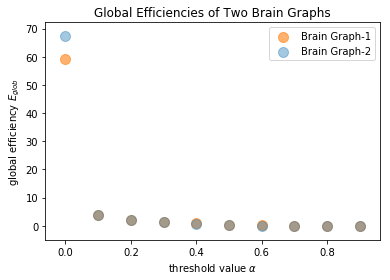

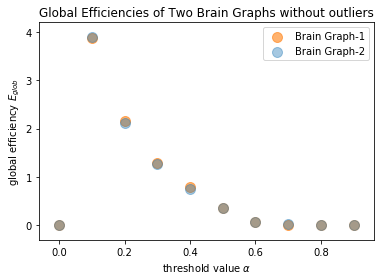

Note that the outliers are set to zero. 
In that case, the first elements are set 0 at threshold 0.0


In [24]:
filename2 = "brainGraph1.mat"
A = sp.loadmat(filename2)["W"]

filename3 = "brainGraph2.mat"
B = sp.loadmat(filename3)["W"]


x_axis = np.arange(0,1,0.1)
#glob_brain1 = np.array([globalEfficiency(np.where(A > i, A, 0)) for i in x_axis])
#glob_brain2 = np.array([globalEfficiency(np.where(B > i, B, 0)) for i in x_axis])

print("Global efficiency results of the Brain Garph-1")
print(glob_brain1)
print("Global efficiency results of the Brain Garph-2")
print(glob_brain2)

plt.scatter(x_axis, glob_brain1, alpha=0.6,  s= 100, color='tab:orange', label="Brain Graph-1")
plt.scatter(x_axis, glob_brain2, alpha=0.4,  s= 100, color='tab:blue', label="Brain Graph-2")

plt.title("Global Efficiencies of Two Brain Graphs")
plt.xlabel(r"threshold value $\alpha$")
plt.ylabel(r"global efficiency $E_{glob}$")
plt.legend(loc="upper right")
plt.show()

glob_brain1_zeroes = np.where(glob_brain1 < 10, glob_brain1, 0)
glob_brain2_zeroes = np.where(glob_brain2 < 10, glob_brain2, 0)

plt.scatter(x_axis, glob_brain1_zeroes, alpha=0.6,  s= 100, color='tab:orange', label="Brain Graph-1")
plt.scatter(x_axis, glob_brain2_zeroes, alpha=0.4,  s= 100, color='tab:blue', label="Brain Graph-2")

plt.title("Global Efficiencies of Two Brain Graphs without outliers")
plt.xlabel(r"threshold value $\alpha$")
plt.ylabel(r"global efficiency $E_{glob}$")
plt.legend(loc="upper right")
plt.show()
print("Note that the outliers are set to zero. \nIn that case, the first elements are set 0 at threshold 0.0")

<hr>

**(2.4) In a second ﬁgure, plot the diffusion efficiency $E_{diff}$ of both matrices against  $\alpha $**.

Diffusion efficiency results of the Brain Garph-1
[ 8.36254242e-003  8.28559072e-003  8.05378305e-003  7.49657952e-003
  6.15184499e-002 -1.23293369e+008 -1.37334631e+012 -1.19570467e+014
  1.61891401e+235  1.00000000e+000]
Diffusion efficiency results of the Brain Garph-2
[8.31400864e-03 8.22111788e-03 7.90195561e-03 7.16790082e-03
 3.03333065e-02 9.08426713e-02 9.17997201e+13 1.04803981e+15
 1.52595730e+13 1.08874278e+00]


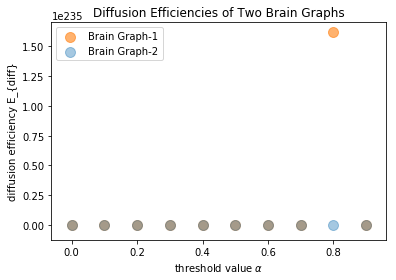

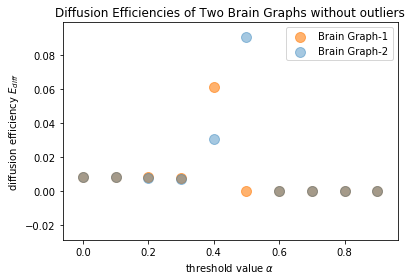

Note that the outliers are set to zero. 
In that case, less than 1e-8 and greater than 0.1 are set to 0


In [87]:
#diff_brain1 = np.array([diffusionEfficiency(np.where(A > i, A, 0)) for i in x_axis])
#diff_brain2 = np.array([diffusionEfficiency(np.where(B > i, B, 0)) for i in x_axis])
print("Diffusion efficiency results of the Brain Garph-1")
print(diff_brain1)
print("Diffusion efficiency results of the Brain Garph-2")
print(diff_brain2)

plt.scatter(x_axis, diff_brain1, alpha=0.6,  s= 100, color='tab:orange', label="Brain Graph-1")
plt.scatter(x_axis, diff_brain2, alpha=0.4,  s= 100, color='tab:blue', label="Brain Graph-2")

plt.title("Diffusion Efficiencies of Two Brain Graphs")
plt.xlabel(r"threshold value $\alpha$")
plt.ylabel(r"diffusion efficiency E_{diff}")
plt.legend(loc="upper left")
plt.show()

diff_brain1_zeroes = np.where((diff_brain1 < 1e-8), 0,diff_brain1)
diff_brain2_zeroes = np.where((diff_brain2 < 1e-8), 0,diff_brain2)
diff_brain1_zeroes = np.where((diff_brain1_zeroes > 0.1), 0,diff_brain1_zeroes)
diff_brain2_zeroes = np.where((diff_brain2_zeroes > 0.1), 0,diff_brain2_zeroes)


plt.scatter(x_axis, diff_brain1_zeroes, alpha=0.6,  s= 100, color='tab:orange', label="Brain Graph-1")
plt.scatter(x_axis, diff_brain2_zeroes, alpha=0.4,  s= 100, color='tab:blue', label="Brain Graph-2")

plt.title("Diffusion Efficiencies of Two Brain Graphs without outliers")
plt.xlabel(r"threshold value $\alpha$")
plt.ylabel(r"diffusion efficiency $E_{diff}$")
plt.legend(loc="upper right")
plt.show()
print("Note that the outliers are set to zero. \nIn that case, less than 1e-8 and greater than 0.1 are set to 0")

<hr>

**(2.5) What conclusions can you derive from previous plots? Compare diffusion and global efficiencies within a single graph and across both graphs.** <br>

##### Global Efficiency:
With increasing threshold value, the global efficiency is dramatically reduced. Because in the beginning, we have large number of nodes in the graph (approximately 13500) then with the threshold values we are removing most of the nodes in the graph. With this operation, the distance between nodes are greatly decreasing. Because the graph is fragmented and the infinity distance has no effect on the global efficiency due to $1/l_{ij}$ gets the zero with infinity distances. (Note that infinity distance means no path between specified nodes). Therefore, global efficiency gives the distance-based result for just remaining nodes. As a result, the global efficiency is getting smaller with increasing threshold values. <br>
It is hard to compare both global efficiency values across both graph. Because the fragmented graphs give so tiny result compared with the beginning efficiency value. Therefore, the scatter figure could not show nice result. On the other hand, when the numerical values are compared, in each threshold, both graph give approximately same values. It is hard to say that one is more core-peripheral than another.


##### Diffusion Efficiency:
Diffusion efficiency calculation suffer from a lot of problems during the implementation. For example, taking inverse of the matrices lead an error due to non-invertible. Also, dive-by-zero was another issue in the implementation. These challenges are solved with some perspectives as explained in the code, but also it shows a problematic view in the scatter figure. Because in some threshold values, these matrix multiplications and so tiny values lead weird results. For example, the diffusion efficiency could not give negative result but in high threshold values, it gives. <br>
Assuming that negative large values (besides the large positive values) are also thought as positive large, the general view of the result make sense. Because the large negative values can be though as mistakes due to tiny number operations. Both positive large values and negative large values are accepted as infinity. With this perspective, an increase in the threshold causes decrease in the diffusion efficiency until some threshold value ($0.4$ for graph-1 and $0.5$ for graph-2). Then, the diffusion efficiency is suddenly increase to the infinity. Infinity results could possibly be to having small connected component as remaining nodes, and information can be easily diffused through on the small connected component. 



<hr>

**(2.6) Plot a morphospace for the set of thresholded brain graphs at $\alpha \in [0 : 0.1 : 0.9]$ , where the x-axis denotes $E_{diff}$ and y-axis denotes $E_{glob}$. Use two different colors to compare the two thresholded graph sets derived from each brain graph, respectively.**

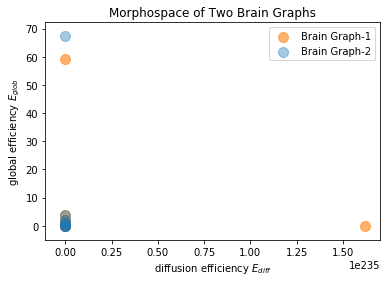

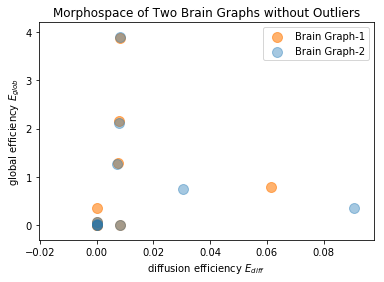

In [36]:
plt.scatter(diff_brain1,glob_brain1, alpha=0.6,  s= 100, color='tab:orange', label="Brain Graph-1")
plt.scatter(diff_brain2,glob_brain2, alpha=0.4,  s= 100, color='tab:blue', label="Brain Graph-2")

plt.title("Morphospace of Two Brain Graphs")
plt.xlabel(r"diffusion efficiency $E_{diff}$")
plt.ylabel(r"global efficiency $E_{glob}$")
plt.legend(loc="upper right")
plt.show()


plt.scatter(diff_brain1_zeroes,glob_brain1_zeroes, alpha=0.6,  s= 100, color='tab:orange', label="Brain Graph-1")
plt.scatter(diff_brain2_zeroes,glob_brain2_zeroes, alpha=0.4,  s= 100, color='tab:blue', label="Brain Graph-2")

plt.title("Morphospace of Two Brain Graphs without Outliers")
plt.xlabel(r"diffusion efficiency $E_{diff}$")
plt.ylabel(r"global efficiency $E_{glob}$")
plt.legend(loc="upper right")
plt.show()

<hr>

**(2.7) Discuss the information ﬂow efficiency for both brain graphs based on your morphospace plot.** 

Here, because of the outliers I set zero to all of them to obtain smoother scatter plot. These fragmented graphs are distributed to everywhere in the plot with respect to their global and diffusion efficiencies. For example, some fragmented graphs from brain graph-2 gets high diffusion efficiency but less global efficiency. This means  the flow of information is easy but the distance are high between nodes. On the other hand, because of the outliers, most of the fragmented graphs are placed on the zero point. 

<hr>

### 3 Graph self-diffusion for image segmentation  
**(3.1) Write a function called selfDiffuse that takes (i) a weighted graph adjacency matrix (i.e., similarity matrix) $W$ and outputs the diffused matrix $W^*$ (check algorithm 3.). Make sure that your algorithm automatically sets the optimal number of diffusion iterations $t^*$ as explained in the paper.**

In [61]:
def selfDiffuse(W, t=0):
    # If t is specified then apply this t; otherwise find the optimum t 
    N = np.matrix(W).shape[0] # number of nodes
    D = np.zeros((N,N))
    d = W.sum(axis=1, dtype=np.float64) # sum the each row to obtain strength of the nodes
    
    # create dioganal matrix S with strength of the nodes
    for i in range(N):
        D[i,i] = d[i]
    
    I = np.identity(N)
    
    ################# STEP-1 ################
    P = np.dot((np.linalg.pinv(D)), W)
    #########################################
    
    if(t == 0):
        ############ CALCULATE T-Optimum #############
        C = 0.05
        epsilon = 1e-8
        #0.00000001
        tr_P = np.matrix.trace(P)
        WP = np.dot(W,P)
        w_P, v_P = np.linalg.eig(P)
        w_P[::-1].sort() # in-place sorting of the eigenvalues of P (transition matrix)
        wP2 = w_P[1] # second highest eigenvalue of the P


        norm_WWPI = np.linalg.norm((W - WP - I), 2)
        Z = (N-tr_P)*(norm_WWPI)
        ln1 = np.log(epsilon/Z)
        ln2 = np.log(wP2 - C)

        tOpt = int(np.ceil(ln1/ln2))
        ##############################################
        print("t optimum : %d" %tOpt)
    else:
        tOpt = t
    
    ################# STEP-2 ################
    W_curr = W.copy()
    for i in range(tOpt):
        W_next = np.dot(W_curr,P) + I
        W_curr = W_next
    #########################################
    
    
    
    ################# STEP-3 ################
    W_opt = np.dot(W_curr, np.linalg.inv(D))
    #########################################
    
    return W_opt

<hr>

**(3.2) Run selfDiffuse on both brain graph adjacency matrices ‘Exercise 2 data/ brainGraph1.mat’ and ‘Exercise 2 data/ brainGraph2.mat’. For each brain graph, visualize both original and diffused matrices.**

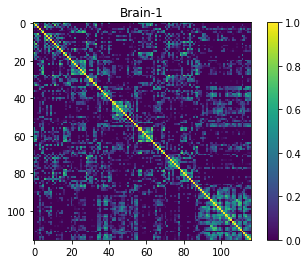

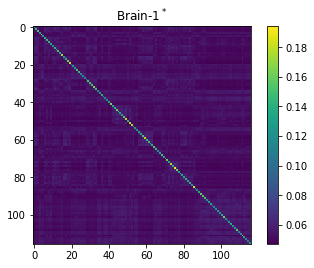

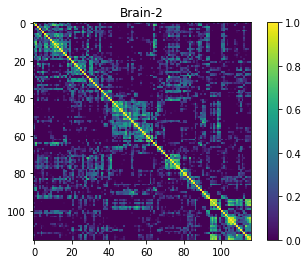

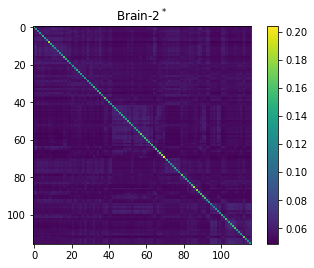

In [364]:
woptA = selfDiffuse(A)
woptB = selfDiffuse(B)


plt.imshow(A)
plt.title("Brain-1")
plt.colorbar()
plt.show()

plt.imshow(woptA)
plt.title(r"Brain-$1^*$")
plt.colorbar()
plt.show()

plt.imshow(B)
plt.title("Brain-2")
plt.colorbar()
plt.show()

plt.imshow(woptB)
plt.title(r"Brain-$2^*$")
plt.colorbar()
plt.show()


<hr>

**(3.3) Given the 2 images taken from the Berkeley Segmentation Data Setc, generate the segmentation maps of each image using the Normalized Cut Python code https://github.com/marktao99/python/blob/master/CVP/samples/ncut.py . Display each original image and its corresponding output segmentation map.**

In [15]:
def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # check for symmetry
    if sum(abs(S-S.T)) > 1e-10:
        print ('not symmetric')
    
    # create Laplacian matrix
    rowsum = sum(abs(S),axis=0)
    D = np.diag(1 / sqrt(rowsum + 1e-6))
    L = np.dot(D,dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = np.linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = array(V[:ndim]).T

    # k-means
    features = whiten(features)
    centroids,distortion = kmeans(features,k)
    code,distance = vq(features,centroids)
        
    return code,V


def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = np.zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
    
    return W

Before: size of images - (321, 481, 3)


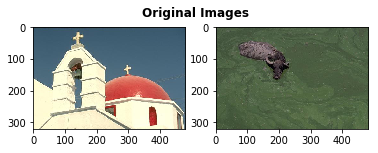

After : size of images - (100, 100, 3)
Original images are cropped to obtain feasible matrix size.
Note that the resized images could not give the nice clustering
results due to corrupt the similarity matrix. Therefore, to obtain
almost-clear segmentation, cropped images seem more appropriate.


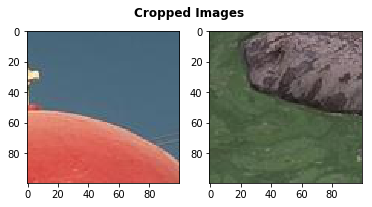

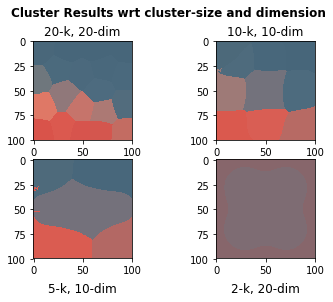

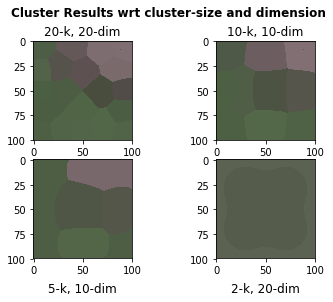

In [537]:
im1=np.array(Image.open("118035.jpg"))#building
im2=np.array(Image.open("80099.jpg")) #buffalo

########### ORIGINAL IMAGES ###########
print("Before: size of images - %s" % (im1.shape,))
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(im1)
f.add_subplot(1,2, 2)
plt.imshow(im2)
f.suptitle('Original Images', fontsize=12, y=0.75, fontweight='bold')
plt.show(block=True)
######################################



########### CROPPED IMAGES ###########
im1 = im1[100:200, 300:400, :]
im2 = im2[50:150, 50:150, :]

print("After : size of images - %s" % (im1.shape,))
print("Original images are cropped to obtain feasible matrix size.")
print("Note that the resized images could not give the nice clustering") 
print("results due to corrupt the similarity matrix. Therefore, to obtain")
print("almost-clear segmentation, cropped images seem more appropriate.")

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(im1)
f.add_subplot(1,2, 2)
plt.imshow(im2)
f.suptitle('Cropped Images', fontsize=12, y=0.85, fontweight='bold')
plt.show(block=True)


######################################


#W1 = ncut_graph_matrix(im1)
#c1,v1 = cluster(W1, 20,20)
#c1_20k_20dim = c1.copy()
#v1_20k_20dim = v1.copy()


#c1,v1 = cluster(W1, 10,10)
#c1_10k_10dim = c1.copy()
#v1_10k_10dim = v1.copy()

#c1,v1 = cluster(W1, 5,10)
#c1_5k_10dim = c1.copy()
#v1_5k_10dim = v1.copy()

#c1,v1 = cluster(W1, 2,20)
#c1_2k_20dim = c1.copy()
#v1_2k_20dim = v1.copy()


f = plt.figure()

f.add_subplot(2,2, 1)
c_reshaped1 = np.reshape(c1_20k_20dim, (100,100))
out1 = color.label2rgb(c_reshaped1, im1, kind='avg')
plt.title("20-k, 20-dim")
plt.imshow(out1)

f.add_subplot(2,2, 2)
c_reshaped1 = np.reshape(c1_10k_10dim, (100,100))
out1 = color.label2rgb(c_reshaped1, im1, kind='avg')
plt.title("10-k, 10-dim")
plt.imshow(out1)

f.add_subplot(2,2, 3)
c_reshaped1 = np.reshape(c1_5k_10dim, (100,100))
out1 = color.label2rgb(c_reshaped1, im1, kind='avg')
plt.title("5-k, 10-dim", y=-0.4)
plt.imshow(out1)

f.add_subplot(2,2, 4)
c_reshaped1 = np.reshape(c1_2k_20dim, (100,100))
out1 = color.label2rgb(c_reshaped1, im1, kind='avg')
plt.title("2-k, 20-dim", y=-0.4)
plt.imshow(out1)

f.suptitle('Cluster Results wrt cluster-size and dimension', fontsize=12, fontweight='bold', y=1)
plt.show(block=True)



''' TO STORE OLD CLUSTER VALUES
c1_20k_20dim
v1_20k_20dim

c1_10k_10dim
v1_10k_10dim

c1_5k_10dim
v1_5k_10dim

c1_2k_20dim
v1_2k_20dim


c2_20k_20dim
v2_20k_20dim

c2_10k_10dim
v2_10k_10dim

c2_5k_10dim
v2_5k_10dim

c2_2k_20dim
v2_2k_20dim

'''



#W2 = ncut_graph_matrix(im2)
#c2,v2 = cluster(W2, 2,20)
#c2_2k_20dim = c2.copy()
#v2_2k_20dim = v2.copy()
f = plt.figure()

f.add_subplot(2,2, 1)
c_reshaped2 = np.reshape(c2_20k_20dim, (100,100))
out2 = color.label2rgb(c_reshaped2, im2, kind='avg')
plt.title("20-k, 20-dim")
plt.imshow(out2)

f.add_subplot(2,2, 2)
c_reshaped2 = np.reshape(c2_10k_10dim, (100,100))
out2 = color.label2rgb(c_reshaped2, im2, kind='avg')
plt.title("10-k, 10-dim")
plt.imshow(out2)

f.add_subplot(2,2, 3)
c_reshaped2 = np.reshape(c2_5k_10dim, (100,100))
out2 = color.label2rgb(c_reshaped2, im2, kind='avg')
plt.title("5-k, 10-dim", y=-0.4)
plt.imshow(out2)

f.add_subplot(2,2, 4)
c_reshaped2 = np.reshape(c2_2k_20dim, (100,100))
out2 = color.label2rgb(c_reshaped2, im2, kind='avg')
plt.title("2-k, 20-dim", y=-0.4)
plt.imshow(out2)

f.suptitle('Cluster Results wrt cluster-size and dimension', fontsize=12, fontweight='bold', y=1)
plt.show(block=True)

On the other hand, to give a segmentation example without cropping, the picture which is also shown in the lecture is used: **starfish**. Here, the original picture with size of **321x481** is imported. Then the function **resize** from _skimage_ library is used to transform original size to the feasible pixel size. Therefore, the image is resized with rank of original size with 321x481. Dimension size of the image is reduced with rank of 5. In the beginning, I forget to **normalize** the image before giving it to the _ncut_ function. As a result, I couldn’t get the nice segmentation results by resizing. And I just used the cropped images to solve the long-run time problem. Then I remembered “normalizing the images” from the lecture. Then the resized image give also nice segmentation result. Now, no need to cropping the images. Normalizing solve the issue encounter on resizing images. Because resizing images could not give the nice segmentation result as well as cropping. But I am leaving both tries to show my progress on this section. 

Note that normalizing means the image values are changed to $(0,1)$ interval from $(0,255)$. The function **resize** from _skimage_ library do as default; therefore I did not normalize the image by hand.

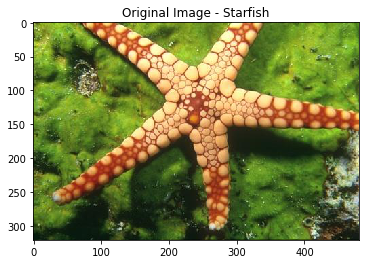

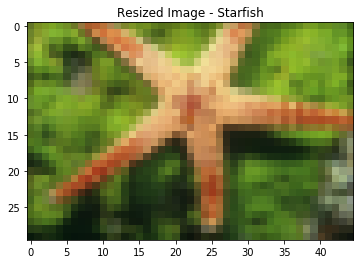

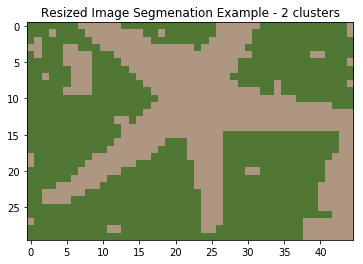

In [57]:
#np.array(Image.open("12003-original.jpg"))
im3=plt.imread("12003-original.jpg") #starfish 

plt.imshow(im3)
plt.title("Original Image - Starfish")
plt.show()

im3_resized = resize(im3, (30,45), anti_aliasing=True)

plt.imshow(im3_resized)
plt.title("Resized Image - Starfish")
plt.show()

W3 = ncut_graph_matrix(im3_resized)
c3,v3 = cluster(W3, 2,2)

# c3_5k5dim


c_reshaped3 = np.reshape(c3, (30,45))
out3 = color.label2rgb(c_reshaped3, im3_resized, kind='avg')
plt.imshow(out3)
plt.title("Resized Image Segmenation Example - 2 clusters")
plt.show()


<hr>

**(3.4) For each image, change the Normalized Cut Python by applying selfDiffuse to the similarity matrix $W$, then use $W^*$ to perform the normalized cut and output the image segmentation map. For each image, display 5 different normalized cut segmentation maps when varying the diffusion threshold from $t = 1$ to $t = 2t^*$**

### Image-1 no:12003, starfish

not symmetric
.
not symmetric
.
t optimum : 515
not symmetric
.
not symmetric
.
not symmetric
.


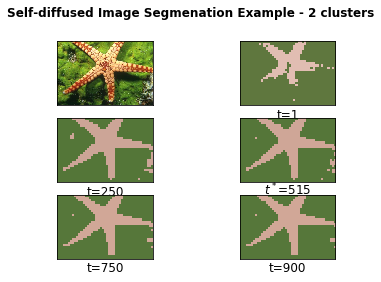

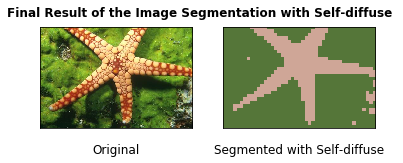

In [92]:
#t=1 , 250, 515, 750, 900
f = plt.figure()

## Original Image
f.add_subplot(3,2, 1)
plt.title("original", y=-1)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(im3)

## t=1
f.add_subplot(3,2,2)
Wopt3 = selfDiffuse(W3, 1)
c3,v3 = cluster(Wopt3, 2,2)
c_reshaped3 = np.reshape(c3, (30,45))
out3 = color.label2rgb(c_reshaped3, im3_resized, kind='avg')
plt.title("t=1", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out3)
print(".")


## t=250
f.add_subplot(3,2,3)
Wopt3 = selfDiffuse(W3, 250)
c3,v3 = cluster(Wopt3, 2,2)
c_reshaped3 = np.reshape(c3, (30,45))
out3 = color.label2rgb(c_reshaped3, im3_resized, kind='avg')
plt.title("t=250", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out3)
print(".")

## t=opt
f.add_subplot(3,2,4)
Wopt3 = selfDiffuse(W3)
c3,v3 = cluster(Wopt3, 2,2)
c_reshaped3 = np.reshape(c3, (30,45))
out33 = color.label2rgb(c_reshaped3, im3_resized, kind='avg')
plt.title(r"$t^*$=515", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out33)
print(".")

## t=750
f.add_subplot(3,2,5)
Wopt3 = selfDiffuse(W3, 750)
c3,v3 = cluster(Wopt3, 2,2)
c_reshaped3 = np.reshape(c3, (30,45))
out3 = color.label2rgb(c_reshaped3, im3_resized, kind='avg')
plt.title("t=750", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out3)
print(".")

## t=900
f.add_subplot(3,2,6)
Wopt3 = selfDiffuse(W3, 900)
c3,v3 = cluster(Wopt3, 2,2)
c_reshaped3 = np.reshape(c3, (30,45))
out3 = color.label2rgb(c_reshaped3, im3_resized, kind='avg')
plt.title("t=900", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out3)
print(".")


f.suptitle('Self-diffused Image Segmenation Example - 2 clusters', fontsize=12, fontweight='bold', y=1)
plt.show(block=True)


f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("Original", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(im3)
f.add_subplot(1,2, 2)
plt.title("Segmented with Self-diffuse", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out33)
f.suptitle('Final Result of the Image Segmentation with Self-diffuse ', fontsize=12, y=0.75, fontweight='bold')
plt.show(block=True)


### Image-2 no:118035, building

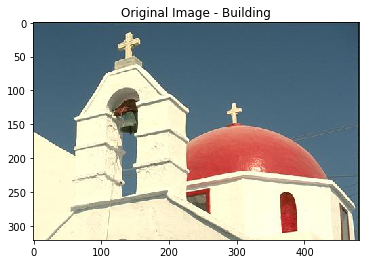

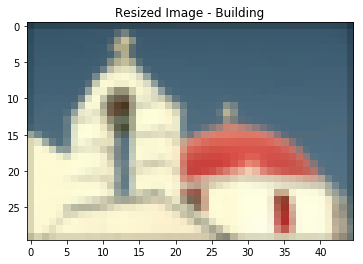

not symmetric
.
not symmetric
.
t optimum : 557
not symmetric
.
not symmetric
.
not symmetric
.


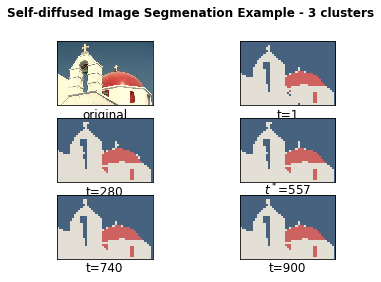

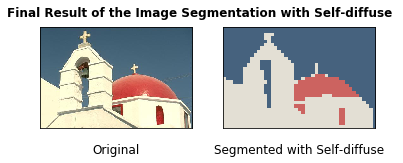

In [93]:
#t=1 , 280, 557, 740, 900

#np.array(Image.open("80099.jpg"))
im4=plt.imread("118035.jpg") #building 

plt.imshow(im4)
plt.title("Original Image - Building")
plt.show()

im4_resized = resize(im4, (30,45), anti_aliasing=True)

plt.imshow(im4_resized)
plt.title("Resized Image - Building")
plt.show()

W4 = ncut_graph_matrix(im4_resized)

f = plt.figure()

## Original Image
f.add_subplot(3,2, 1)
plt.title("original", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(im4)

## t=1
f.add_subplot(3,2,2)
Wopt4 = selfDiffuse(W4, 1)
c4,v4 = cluster(Wopt4, 3,3)
c_reshaped4 = np.reshape(c4, (30,45))
out4 = color.label2rgb(c_reshaped4, im4_resized, kind='avg')
plt.title("t=1", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out4)
print(".")


## t=280
f.add_subplot(3,2,3)
Wopt4 = selfDiffuse(W4, 250)
c4,v4 = cluster(Wopt4, 3,3)
c_reshaped4 = np.reshape(c4, (30,45))
out4 = color.label2rgb(c_reshaped4, im4_resized, kind='avg')
plt.title("t=280", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out4)
print(".")

## t=opt
f.add_subplot(3,2,4)
Wopt44 = selfDiffuse(W4)
c44,v44 = cluster(Wopt44, 3,3)
c_reshaped4 = np.reshape(c44, (30,45))
out44 = color.label2rgb(c_reshaped4, im4_resized, kind='avg')
plt.title(r"$t^*$=557", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out44)
print(".")

## t=740
f.add_subplot(3,2,5)
Wopt4 = selfDiffuse(W4, 750)
c4,v4 = cluster(Wopt4, 3,3)
c_reshaped4 = np.reshape(c4, (30,45))
out4 = color.label2rgb(c_reshaped4, im4_resized, kind='avg')
plt.title("t=740", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out4)
print(".")

## t=900
f.add_subplot(3,2,6)
Wopt4 = selfDiffuse(W4, 900)
c4,v4 = cluster(Wopt4, 3,3)
c_reshaped4 = np.reshape(c4, (30,45))
out4 = color.label2rgb(c_reshaped4, im4_resized, kind='avg')
plt.title("t=900", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out4)
print(".")

f.suptitle('Self-diffused Image Segmenation Example - 3 clusters', fontsize=12, fontweight='bold', y=1)
plt.show(block=True)


f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("Original", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(im4)
f.add_subplot(1,2, 2)
plt.title("Segmented with Self-diffuse", y=-0.3)
plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.imshow(out44)
f.suptitle('Final Result of the Image Segmentation with Self-diffuse ', fontsize=12, y=0.75, fontweight='bold')
plt.show(block=True)